In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [20]:
from IPython.display import HTML, display

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td><h4>%s</h4><td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

\begin{align*}
\frac{dS_i}{dt} & = \sum_{j=1,N}\left(-(1-\mu)\beta \frac{S_iI_j}{N_j}\right) \\
\frac{dE_i}{dt} & = \sum_{j=1,N}\left((1-\mu)\beta \frac{S_iI_j}{N_j}\right) - \alpha E_i \\
\frac{dI_i}{dt} & = \alpha E_i-(1-\delta)\gamma I_i-\delta\varepsilon I_i-(1-\zeta)\gamma I_i-\zeta I_i \\
\frac{dQ_i}{dt} & = \zeta I_i - \eta Q_i \\
\frac{dR_i}{dt} & = (1-\delta)\gamma I_i + (1-\zeta)\gamma I_i + \eta Q_i \\
\frac{dD_i}{dt} & = \delta\varepsilon I_i
\end{align*}
\begin{equation*}
S_i+E_i+I_i+Q_i+R_i+D_i = N_i
\end{equation*}

| Parameters | Value       | Function        |
|------------|-------------|-----------------|
|$R_0$       | 5     | Infectivity     |
|$\alpha$    | $1/5$ | Incubation rate |
|$\gamma$    | $1/5$ | Infectious rate |
|$\mu   $    | $\mu(t,i,j)$ | Efficacy of protective measures |


In [2]:
def plotseiqrd(ipop,t, y, yaxisformat='linear', yaxislim = 0):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, y[:,i_S,ipop], 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, y[:,i_E,ipop], 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, y[:,i_I,ipop], 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, y[:,i_R,ipop], 'C1', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, y[:,i_Q,ipop], 'g', alpha=0.7, linewidth=2, label='Quarantine')
    ax.plot(t, y[:,i_D,ipop], 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, np.sum(y[:,:,ipop],axis = 1), 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='both', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
  
    plt.show();

In [81]:
Nvariables = 6
i_S = 0; i_E = 1; i_I = 2; i_Q = 3; i_R = 4; i_D = 5
def rhs(t,y,Hq):
    global Npopulations, N, alpha, beta, gamma, delta, epsilon, zeta, eta
    global i_S, i_E, i_I, i_Q, i_R, i_D
    ydot = np.zeros_like(y)
    mu = efficacy_pm(t)
    for i in range(Npopulations):
        for j in range(Npopulations):
            ydot[i_S,i] += -(1 - mu[i,j]) * beta * y[i_S,i] * y[i_I,j] / N[j]
        ydot[i_E,i] = -ydot[i_S,i] - alpha * y[i_E,i]
        ydot[i_I,i] = alpha * y[i_E,i] - (1 - delta[i]) * gamma * y[i_I,i] - delta[i] * epsilon * y[i_I,i] - Hq*(1 - zeta[i]) * gamma * y[i_I,i] - Hq*zeta[i] * y[i_I,i]
        ydot[i_Q,i] = Hq*zeta[i] * y[i_I,i] - Hq*eta * y[i_Q,i]
        ydot[i_R,i] = (1 - delta[i]) * gamma * y[i_I,i] + Hq*(1 - zeta[i]) * gamma * y[i_I,i] + Hq*eta * y[i_Q,i]
        ydot[i_D,i] = delta[i] * epsilon * y[i_I,i]
    return ydot

def advance_AB(dt,y,f_n,f_nm1):
    return y + dt * (3/2 * f_n - 1/2 * f_nm1)
def advance_AM(dt,y,f_np1,f_n):
    return y + dt * (1/2 * f_np1 + 1/2 * f_n)

def forecast(y,dt,Ntsteps,Hq):
    t = 0
    f_n = rhs(0,y[0,:,:],Hq)
    tplot = np.array([t])
    for it in range(Ntsteps):
        f_nm1 = np.copy(f_n)
        f_n = rhs(t,y[it,:,:],Hq)
    #     y[it+1,:,:] = advance(y[it,:,:],f_n,f_nm1)
        y_np1 = advance_AB(dt,y[it,:,:],f_n,f_nm1)
        f_np1 = rhs(t+dt,y_np1,Hq)
        y[it+1,:,:] = advance_AM(dt,y[it,:,:],f_np1,f_n)
        t += dt
        tplot = np.append(tplot,t)
    return tplot,y



In [100]:
Npopulations = 3
t_study = 7*15 #days
dt = 0.01 # days
Ntsteps = round(t_study/dt)

# time scales
t_incubation = 5
t_infectious = 4
t_quarantine = 14
t_rtc_isolation = 7
t_test_delay = 1
t_death = 9

def efficacy_pm(t):
    global Npopulations,t_rtc_isolation,t_test_delay
    mu_ = np.zeros((Npopulations,Npopulations))
    mu_[0,0] = 0.2
    if t < t_rtc_isolation:
        mu_[0,1] = 1.0
        mu_[1,1] = 0.6
        mu_[1,2] = 1.0
    elif (t >= t_rtc_isolation) and (t < t_rtc_isolation + t_test_delay):
        mu_[0,1] = 0.4
        mu_[1,1] = 0.4
        mu_[1,2] = 0.9
    elif t > t_rtc_isolation + t_test_delay:
        mu_[0,1] = 0.2
        mu_[1,1] = 0.2
        mu_[1,2] = 0.8
    mu_[1,0] = mu_[0,1]
    mu_[2,1] = mu_[1,2]
    mu_[0,2] = 0.8
    mu_[2,0] = mu_[0,2]
    mu_[2,2] = 0.9
    return mu_

#Nominal R_0
R_0 = 4

# mortality rate
delta = np.array([0.01,0.01,0.02])

# quarantine fraction
zeta = np.array([0.5,0.5,0.5])
Hq = 1.

#model constants
alpha = 1 / t_incubation
gamma = 1 / t_infectious
epsilon = 1 / t_death
eta = 1 / t_quarantine

beta = gamma * R_0

Population_size = np.array([3000,8000,30000])
infected_population = np.array([1, 1, 10])
N = np.copy(Population_size)
n = np.copy(infected_population)
y = np.zeros((Ntsteps+1,Nvariables,Npopulations))

y[0,i_S,:] = N[:] - n[:]
y[0,i_I,:] = n[:]
tplot,y = forecast(y,dt,Ntsteps,Hq)


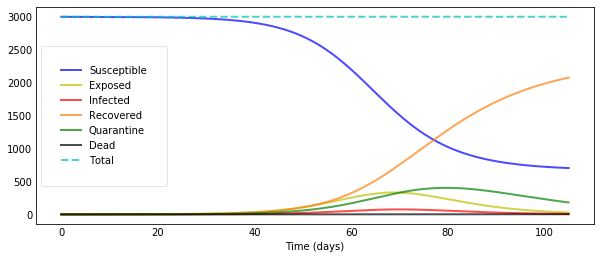

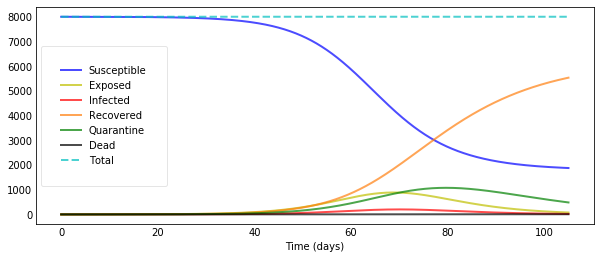

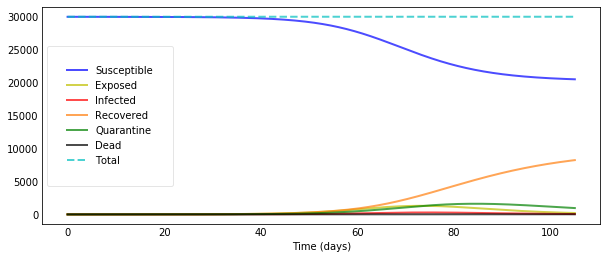

In [101]:
for i in range(Npopulations):
    plotseiqrd(i,tplot, y)


In [102]:
import tabletext

data = [["Group:","VT Students", "non-VT Students", "Student Total", "non Students"],
        ["Population:",N[0],N[1],np.sum(N[0:2]),N[2]],
        ["Initial infected:",n[0],n[1],np.sum(n[0:2]),n[2]],
        ["max infectious:",round(np.amax(y[:,i_I,0])) ,round(np.amax(y[:,i_I,1])),round(np.amax(y[:,i_I,0]+y[:,i_I,1])),round(np.amax(y[:,i_I,2]))],
        ["max quarantine:",round(np.amax(y[:,i_Q,0])) ,round(np.amax(y[:,i_Q,1])),round(np.amax(y[:,i_Q,0]+y[:,i_Q,1])),round(np.amax(y[:,i_Q,2]))],
        ["total infected:",round(y[-1,i_R,0]+y[-1,i_Q,0]) ,round(y[-1,i_R,1]+y[-1,i_Q,1]), round(y[-1,i_R,0]+y[-1,i_R,1]+y[-1,i_Q,0]+y[-1,i_Q,1]),round(y[-1,i_R,2]+y[-1,i_Q,2])],
        ["total death:",round(y[-1,i_D,0]) ,round(y[-1,i_D,1]), round(y[-1,i_D,0]+y[-1,i_D,1]),round(y[-1,i_D,2])]]
        #         ["max quarantine:",,np.amax(y[:,i_Q,0]) ,np.amax(y[:,i_Q,1]),np.amax(y[:,i_Q,0]+y[:,i_Q,1]),np.amax(y[:,i_Q,2])]]

display_table(data)

## Verification

In [34]:
def rhs_test(t,y):
    global Npopulations, N, alpha, beta, gamma, delta, epsilon, zeta, eta
    global i_S, i_E, i_I, i_Q, i_R, i_D
    ydot = np.zeros_like(y)
    for i in range(Npopulations):
        ydot[i_S,i] = 1.0
        ydot[i_E,i] = 2*t
        ydot[i_I,i] = 3*t**2
        ydot[i_Q,i] = 2*np.pi*np.cos(2*np.pi*t)
        ydot[i_R,i] = 2*np.exp(2*t)
        ydot[i_D,i] = 0
    return ydot

In [ ]:
Npopulations = 1
t_study = 1 #7*30 #days
dt = 0.001 # days
Ntsteps = round(t_study/dt)

# time scales
t_incubation = 5
t_infectious = 4
t_quarantine = 14
t_rtc_isolation = 7
t_test_delay = 1
t_death = 9

#Nominal R_0
R_0 = 5

# mortality rate
delta = np.array([0.2])

# quarantine fraction
zeta = np.array([0.4])
Hq = 0.

#model constants
alpha = 1 / t_incubation
gamma = 1 / t_infectious
epsilon = 1 / t_death
eta = 1 / t_quarantine

beta = gamma * R_0

zeta = np.array([0.4]) #Probability that COVID-19 patients follow quarantine protocol
N = np.copy(Population_size)
n = np.copy(infected_population)
y = np.zeros((Ntsteps+1,Nvariables,Npopulations))
y[0,i_Q,0] = 0.
f_n = rhs(-dt,y[0,:,:])
t = 0
tplot = np.array([t])
for it in range(Ntsteps):
    f_nm1 = np.copy(f_n)
    f_n = rhs_test(t,y[it,:,:])
    y[it+1,:,:] = advance(y[it,:,:],f_n,f_nm1)
    t += dt
    tplot = np.append(tplot,t)

   
    
    
    

In [ ]:
plt.plot(tplot,y[:,i_Q,0])
plt.plot(tplot,np.sin(2*np.pi*tplot),'o')
plt.show()